# QSAR Modelling

The notebook demonstrates how `chemicalspace` can provide useful tools for QSAR modelling, using a CDK2 activity dataset as an example.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from chemicalspace import ChemicalSpace
from rdkit.Chem import Draw
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score

Draw.rdDepictor.SetPreferCoordGen(True)

sns.set_style("darkgrid")

## Load the `ChemicalSpace`


In [2]:
space = ChemicalSpace.from_sdf("data/chembl_cdk2.sdf.gz", scores_prop="active")
if space.scores is not None:
    space.scores = space.scores.astype(int)
space

<ChemicalSpace: 1789 molecules | 1789 indices | 1789 scores>

### Inspect the dataset

We project the dataset into a 2D space using TSNE, and also cluster it into 5 clusters.


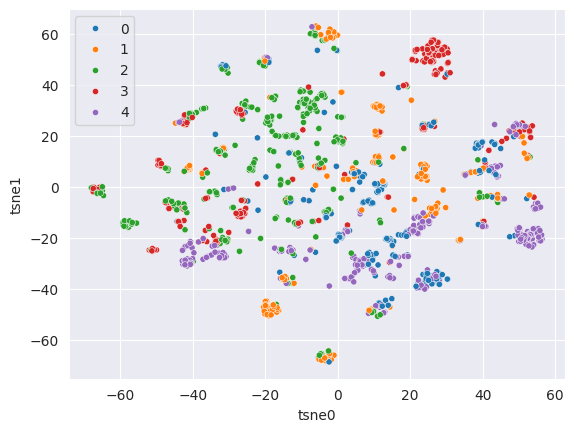

In [7]:
proj = space.project(perplexity=20)
labels = space.cluster(n_clusters=5)

sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette="tab10", s=20)
plt.xlabel("tsne0")
plt.ylabel("tsne1")
plt.show()

## QSAR Modelling - Cluster Splits CV

We train a `RandomForest` classifier, and we evaluate its performance with a 5-fold cluster split cross-validation.

`ChemicalSpace.splot` yields train and test `ChemicalSpace`s at each fold,  
which can be used to train and evaluate the model.

A cluster split allows to evaluate the model on unseen clusters, which is a more realistic evaluation than a random split,  
and a better approach to assess the generalization of the model.


In [9]:
for i, (train_chunk, test_chunk) in enumerate(space.split(n_splits=5)):
    y_train = train_chunk.scores
    y_test = test_chunk.scores

    model_split = RandomForestClassifier(random_state=42)
    model_split.fit(train_chunk.features, y_train)
    y_pred = model_split.predict(test_chunk.features)
    y_pred_proba = model_split.predict_proba(test_chunk.features)[:, 1]

    train_size, test_size = len(y_train), len(y_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    print(
        f"Split: {i:2d} | Train: {train_size:3d} | Test: {test_size:3d} | MCC: {mcc:.3f}, AUC: {auc:.3f}"
    )

Split:  0 | Train: 1501 | Test: 288 | MCC: 0.551, AUC: 0.853
Split:  1 | Train: 1471 | Test: 318 | MCC: 0.432, AUC: 0.729
Split:  2 | Train: 1304 | Test: 485 | MCC: 0.362, AUC: 0.793
Split:  3 | Train: 1475 | Test: 314 | MCC: 0.508, AUC: 0.781
Split:  4 | Train: 1405 | Test: 384 | MCC: 0.298, AUC: 0.767


## QSAR Modelling - Holdout Set

We now train a similar model, but we hold out a test set consisting of compounds that are similar to a query molecule.

This is done to assess generalization to specific subspaces of the chemical space.


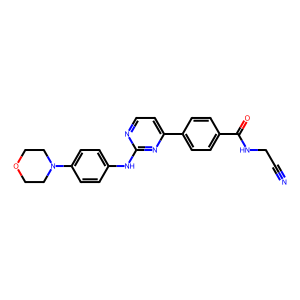

In [10]:
query = space.mols[-12]
Draw.MolToImage(query)

102 neighbors


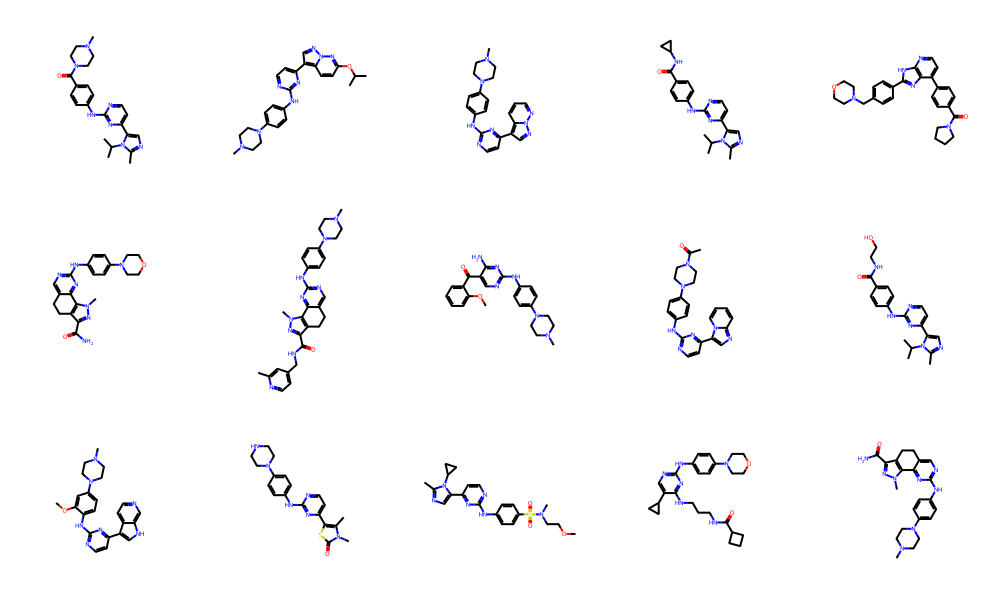

In [11]:
neighbors_idx = space.find_neighbors(query, radius=0.7)
mask = np.full(len(space), False)
mask[neighbors_idx] = True

print(f"{mask.sum()} neighbors")
Draw.MolsToGridImage(space.mols[mask][:15], molsPerRow=5)

### Train the model


In [12]:
space_train = space[mask]
space_holdout = space[~mask]

model = RandomForestClassifier(random_state=42)
model.fit(space_train.features, space_train.scores)

RandomForestClassifier(random_state=42)

As expected, the performance is not brilliant


In [13]:
y_pred = model.predict(space_holdout.features)
mcc = matthews_corrcoef(space_holdout.scores, y_pred)

print(f"MCC: {mcc:.3f}")

MCC: 0.201
